In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import sklearn
from sklearn import metrics
import pydicom
from matplotlib.patches import Rectangle
from collections import namedtuple, defaultdict

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
PATH = Path('/home/paperspace/data/pneumonia/toy')

In [4]:
BBox = namedtuple('BBox', 'x1 y1 x2 y2')

In [5]:
file2target = pd.read_csv(PATH/'train_targets.csv')
file2boxes = pd.read_csv(PATH/'train_rotated.csv')
file2boxes.set_index('patientId', inplace=True)
train_n = file2target.shape[0]
train_n

5000

In [6]:
def expand(str):
    while len(str.split() ) < 16:
        str = str+" 0 0 0 0"
    return str
file2boxes['bboxes']=file2boxes['bboxes'].apply(expand)
file2boxes.to_csv(PATH/'train_rotated.csv')

In [7]:
bbox_map = defaultdict(list)
for file_name ,row in file2boxes.iterrows():
    if not pd.isna(row['bboxes']):
        spl = row['bboxes'].split()
        for i in range(0,len(spl),4):
            box = BBox(int(spl[i]),int(spl[i+1]),int(spl[i+2]),int(spl[i+3]))
            bbox_map[file_name].append(box)

In [8]:
val_idxs = get_cv_idxs(train_n)
val_idxs.shape

(1000,)

In [9]:
bs  = 128
arch = resnet34
sz=128

In [10]:
class OverSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, counts):
        indices =[]
        for idx, cnt in enumerate(counts):
            indices = indices +[idx]*int(cnt)
        self.ind_arr = np.array(indices)
        np.random.shuffle(self.ind_arr)
    
    def __len__(self):
        return len(self.ind_arr)
    
    def __iter__(self):
        return iter(self.ind_arr)

In [11]:
def get_data(sz):
    augs = [RandomFlip(tfm_y=TfmType.COORD),
            RandomRotate(5, p=0.5,tfm_y=TfmType.COORD),
            RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]
    tfms = tfms_from_model(arch, sz, tfm_y=TfmType.COORD, aug_tfms=augs)
    data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train_rotated.csv',
                                    val_idxs=val_idxs, tfms=tfms,bs=bs,continuous=True,num_workers=8)
    '''train_ds = data.trn_ds
    train_dl = data.trn_dl
    all_y=np.ndarray(0)
    for x,y in train_dl.__iter__():
        all_y =np.append(all_y, y.cpu().numpy())

    weights = all_y*3 + 1
    sampler = OverSampler(weights)
    train_dl.sampler = sampler
    train_dl.batch_sampler=torch.utils.data.sampler.BatchSampler(sampler,bs,False)
    '''
    print(tfms[0])
    print(tfms[1])
    return data

In [12]:
def class_data(sz):
    tfms = tfms_from_model(arch, sz)
    data = ImageClassifierData.from_csv(PATH, 'train', PATH/'train_targets.csv', val_idxs=val_idxs, tfms=tfms)
    return data

In [13]:
learner = ConvLearner.pretrained(arch, class_data(sz))

In [14]:
learner.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [15]:
data = get_data(sz)

[<fastai.transforms.Scale object at 0x7fe09fbe2f60>, <fastai.transforms.RandomFlip object at 0x7fe09fbe20f0>, <fastai.transforms.RandomRotate object at 0x7fe09fbe2a20>, <fastai.transforms.RandomLighting object at 0x7fe09fbe2b70>, <fastai.transforms.RandomCrop object at 0x7fe09fbe2d30>, <fastai.transforms.Normalize object at 0x7fe09fbe2c50>, <fastai.transforms.ChannelOrder object at 0x7fe09fbe2fd0>]
[<fastai.transforms.Scale object at 0x7fe09fbe2be0>, <fastai.transforms.CenterCrop object at 0x7fe09fbe2940>, <fastai.transforms.Normalize object at 0x7fe09fbe2c50>, <fastai.transforms.ChannelOrder object at 0x7fe09fbe2e10>]


In [16]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(512*4*4,16))
learn = ConvLearner.pretrained(arch, data, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [17]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [18]:
def bb_hw(bb): return np.array([bb[1], bb[0], bb[3]-bb[1], bb[2]-bb[0]])

In [19]:
def draw_rect(ax, b, color='red'):
    patch = ax.add_patch(Rectangle(b[:2],*b[-2:], fill=False, edgecolor=color))

In [20]:
def draw_rects(ax, boxes, color='red'):
    for i in range(0,len(boxes),4):
        draw_rect(ax,bb_hw(boxes[i:i+4]),color)

In [21]:
def display(file_name,ax=None):
    if ax is None:
        _,ax = plt.subplots(1,1)
    ax.imshow(PIL.Image.open(PATH/file_name))
    boxes =bbox_map[str(Path(file_name).name)]
    for box in boxes:
        x1,y1,w,h = bb_hw(box)
        ax.add_patch(Rectangle(xy=(x1,y1),width=w,height=h,alpha = 0.5, fill=False, color='red'))

In [22]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

[BBox(x1=29, y1=32, x2=71, y2=58),
 BBox(x1=20, y1=80, x2=87, y2=101),
 BBox(x1=0, y1=0, x2=0, y2=0),
 BBox(x1=0, y1=0, x2=0, y2=0)]

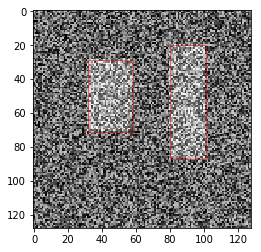

In [23]:
name0 = data.aug_dl.dataset.fnames[14]
display(name0)
bbox_map[Path(name0).name]

[30. 70. 73. 98. 17. 26. 86. 51.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 29.  32.  71.  58.  20.  80.  87. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 29.  30.  73.  58.  18.  77.  86. 102.   0.   0.   0.   0.   0.   0.   0.   0.]
[29. 70. 71. 96. 20. 27. 87. 48.  0.  0.  0.  0.  0.  0.  0.  0.]
[30. 70. 73. 99. 17. 25. 86. 51.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 29.  32.  71.  58.  20.  80.  87. 101.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 28.  32.  71.  59.  20.  80.  88. 102.   0.   0.   0.   0.   0.   0.   0.   0.]
[27. 68. 71. 96. 21. 24. 89. 50.  0.  0.  0.  0.  0.  0.  0.  0.]
[28. 69. 71. 96. 20. 26. 88. 49.  0.  0.  0.  0.  0.  0.  0.  0.]


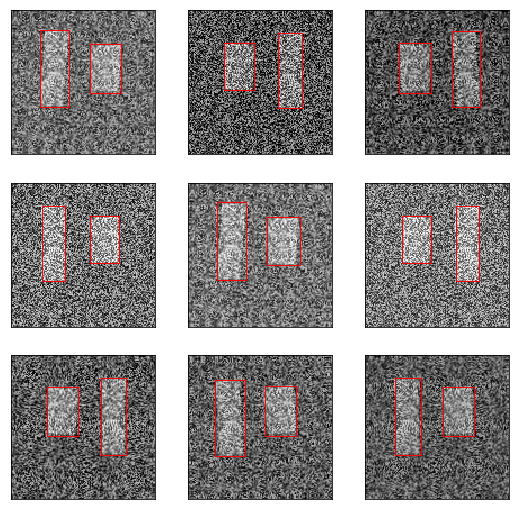

In [24]:
idx=14
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(data.aug_dl))
    ima=data.val_ds.denorm(to_np(x))[idx]
    b = to_np(y[idx])
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, bb_hw(b[0:4]))
    draw_rect(ax, bb_hw(b[4:8]))
    draw_rect(ax, bb_hw(b[8:12]))

 81%|████████▏ | 26/32 [00:10<00:02,  2.42it/s, loss=15.3]

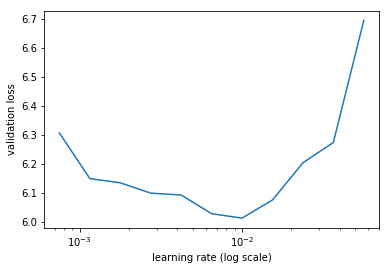

In [25]:
learn.lr_find()
learn.sched.plot()

In [26]:
%time learn.fit(1e-3, 3)

epoch      trn_loss   val_loss                            
    0      5.766493   5.499525  
    1      5.127191   4.865058                            
    2      4.657439   4.554939                            
CPU times: user 1min 16s, sys: 17.4 s, total: 1min 33s
Wall time: 40.4 s


[array([4.55494])]

In [27]:
learn.unfreeze()

In [33]:
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                            
    0      1.216457   1.228663  
    1      1.215667   1.236139                            
    2      1.194294   1.213508                            
    3      1.178777   1.233919                            
    4      1.167164   1.227998                            
    5      1.130017   1.211705                            
    6      1.125347   1.20708                             


[array([1.20708])]

In [34]:
preds = learn.predict()

In [35]:
def show_prediction(img_data, pred, truth, ax):
    show_img(img_data,ax=ax)
    draw_rects(ax, truth)
    draw_rects(ax, pred, 'blue')

In [39]:
BBox = namedtuple('BBox', 'x1 y1 x2 y2')

def area(b):
    if b.x1 >= b.x2 or b.y1 >= b.y2: return 0
    return (b.x2-b.x1)*(b.y2 - b.y1)
area(BBox(0,0,100,100))

def ar2boxes(b):
    res =[]
    for i in range(0,len(b),4):
        bint = [int(round(x)) for x in b[i:i+4]]
        box = BBox(*bint)
        if area(box) >1: res.append(box)
    return res
print(preds[0])
print(ar2boxes(preds[0]))

def IoU(b1, b2):
    ab1 = area(b1)
    ab2 = area(b2)
    if ab1 <1 or ab2 < 1: return 0
    inter = BBox(max(b1.x1,b2.x1), max(b1.y1,b2.y1), min(b1.x2,b2.x2), min(b1.y2,b2.y2))
    union = ab1+ab2-area(inter)
    return area(inter)/union

def score_tre(tresh, preds, actuals):
    pred_hits = np.full(len(preds), False)
    act_hits = np.full(len(actuals), False)
    for pi in range(len(preds)):
        for ai in range(len(actuals)):
            if pred_hits[pi] or act_hits[ai]: continue
            b1,b2 = preds[pi], actuals[ai]
            if IoU(b1,b2) >= tresh: pred_hits[pi]=act_hits[ai]=True
    tp = np.sum(pred_hits == True)
    fp = np.sum(pred_hits == False)
    fn = np.sum(act_hits == False)
    #print(tp,fp,fn)
    return tp / (tp+fp+fn)
p = [BBox(0,10,30,40)]; a= [BBox(10,10,40,40),BBox(40,40,50,50)]
score_tre(.1, p,a)

def score(preds, actuals):
    ret =0
    for thr in np.linspace(0.4,0.75,8):
        ret+= score_tre(thr, preds,actuals)
    return ret/8
p = [BBox(0,10,30,40)]; a= [BBox(10,10,40,40),BBox(40,40,50,50)]
score(p,a)    

def score_all(pred, truth):
    assert len(pred) == len(truth)
    sum = 0
    cnt = 0
    for idx in range(len(pred)):
        pred_box = ar2boxes(pred[idx])
        true_box = ar2boxes(truth[idx])
        if pred_box or true_box:
            sum += score(pred_box, true_box)
            cnt += 1
    return sum / cnt
score_all(preds, data.val_ds.y)

In [36]:
x = data.val_ds.get_x(0)
y = data.val_ds.get_y(0)
print(y)
x2,y2 = data.val_ds.get1item(0)
sc = data.val_ds.transform.tfms[0]
x2,y2 = sc(x,y)
print(y2)


[ 57.  92.  78. 114.  60.  18.  87.  52.   0.   0.   0.   0.   0.   0.   0.   0.]
[ 57.  92.  78. 114.  60.  18.  87.  52.   0.   0.   0.   0.   0.   0.   0.   0.]


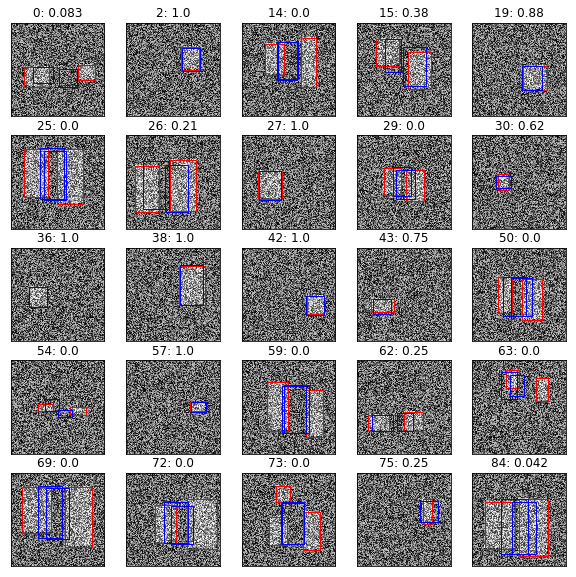

In [49]:
val_it = iter(data.val_dl)
x,y=next(val_it)
_,axs = plt.subplots(5,5,figsize=(10,10))
axs = axs.flatten()
idx=0
denx = data.val_ds.denorm(to_np(x))
y = to_np(y)
for ax in axs:
    while y[idx][0]==0 :idx +=1
    ima=denx[idx]
    #print(y[idx])
    #print(data.val_ds.y[idx])
    sc = score(ar2boxes(preds[idx]), ar2boxes(y[idx]))
    ax.set_title(f'{idx}: {sc:.2}')
    show_prediction(ima,preds[idx], y[idx], ax)
    idx+=1


[BBox(x1=59, y1=67, x2=92, y2=94)]
[BBox(x1=59, y1=68, x2=91, y2=101)]
0.7461883408071749


1.0

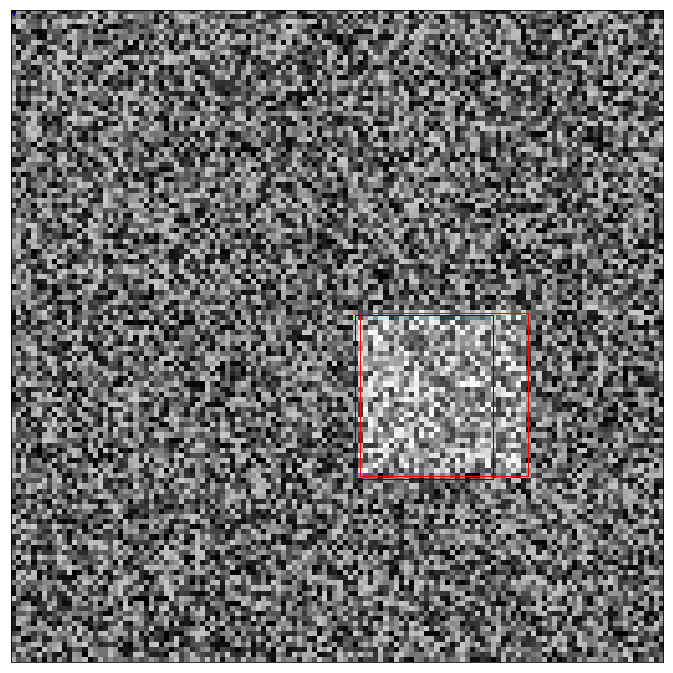

In [47]:
_,ax = plt.subplots(1,1,figsize=(12,12))
idx=19
ima=data.val_ds.denorm(to_np(x))[idx]
show_prediction(ima,preds[idx], to_np(y[idx]), ax)
pred_box = ar2boxes(preds[idx])
true_box = ar2boxes(to_np(y[idx]))
print(pred_box)
print(true_box)
print(IoU(pred_box[0], true_box[0]))
score_tre(0.7, pred_box,true_box)